# **Week 5: Painting**

In [15]:
import sys
!{sys.executable} -m pip install pandas kaggle numpy matplotlib seaborn opencv-python pillow tensorflow keras-tuner scikit-learn 

In [2]:
import os
import shutil

import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import seaborn
import numpy as np
import tensorflow as tf
import keras
import gc


# Problem, Data & EDA

The goal of my project is to build models that can generate images that resemble target images (Monets in this case) from [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)

For EDA, I will need to preprocess the images. I will put them into batches and resize them for training efficiency.

I'll make sure that only existing images are included by grabbing images wile path that exists. We will see that there are 300 monets in the source with width by height or 256 by 256.

<div style="border-left: 6px solid red; padding: 10px; background-color: rgba(255, 0, 0, 0.1); font-weight: bold;">
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.
</div>

In [4]:
!kaggle competitions download -c gan-getting-started

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
with zipfile.ZipFile("gan-getting-started.zip", 'r') as zip_ref:
    zip_ref.extractall("gan-getting-started-data/")

<div style="border-left: 6px solid red; padding: 10px; background-color: rgba(255, 0, 0, 0.1); font-weight: bold;">
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 
</div>

In [3]:
# make directory if it doesn't exist
monet_dir = "gan-getting-started-data/monet_jpg"
os.makedirs(os.path.join(monet_dir, 'monet'), exist_ok=True)

# move each monet into a subdirectory structure required
for filename in os.listdir(monet_dir):
    if filename.endswith('.jpg'):
        shutil.move(os.path.join(monet_dir, filename), os.path.join(monet_dir, 'monet', filename))

# rename monet_dir to include subdirectory
monet_dir = monet_dir + '/monet'

# define the monets as an array of the paths existing
monets = [f for f in os.listdir(monet_dir)]


*Here's where we find we have 300 monets.*

In [33]:
print(len(monets))

300


**Next, I'd like to look at a sample of what the Monets look like.**

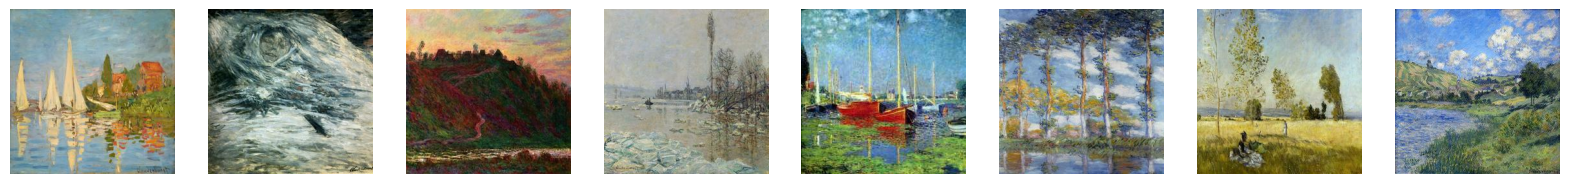

In [4]:
# load example monets
def load_samples(paths, n=8):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        img = Image.open(paths[i])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

load_samples([os.path.join(monet_dir, img) for img in monets[:8]])

*Below, I will look at the sizes of the input images.*

In [5]:
monet_sizes = []

for monet in monets:
    with Image.open(os.path.join(monet_dir, monet)) as img:
        monet_sizes.append(img.size)

monet_size_df = pd.DataFrame(monet_sizes, columns=["width", "height"])
monet_size_df.describe()

width  height
count  300.0   300.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0

**Next, I'll look at the pixel distribution of the Monets.**

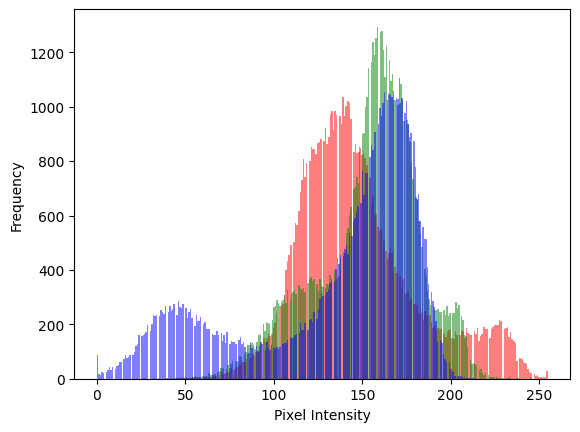

In [6]:
# pixel intensity histogram
def plot_img_hist(path):
    img = np.array(Image.open(path))
    plt.hist(img[:, :, 0].ravel(), bins=256, color='red', alpha=0.5)
    plt.hist(img[:, :, 1].ravel(), bins=256, color='Green', alpha=0.5)
    plt.hist(img[:, :, 2].ravel(), bins=256, color='Blue', alpha=0.5)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_img_hist(os.path.join(monet_dir, monets[0]))

**Next, I'll preprocess the images and plot them.**

In [7]:
# preprocess images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

monet_gen = datagen.flow_from_directory(monet_dir[:-6], target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode=None, subset='training')
val_gen = datagen.flow_from_directory(monet_dir[:-6], target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode=None, subset='validation')


Found 240 images belonging to 1 classes.
Found 60 images belonging to 1 classes.


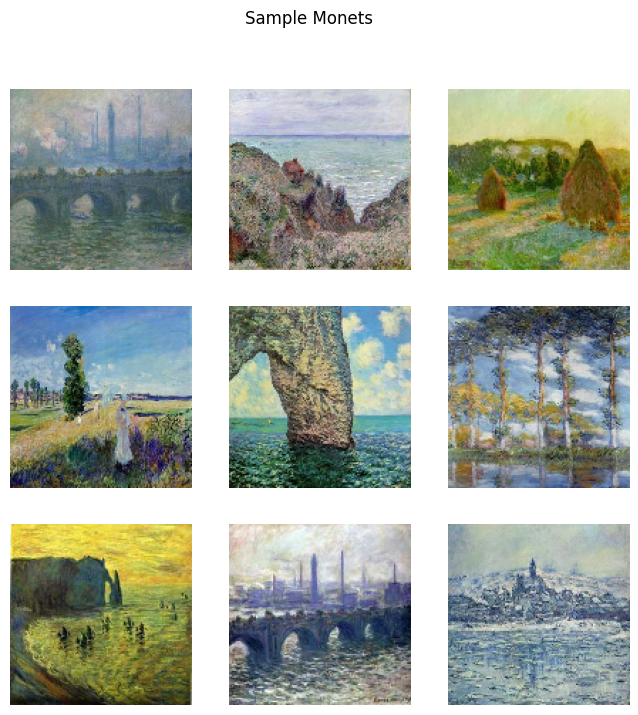

In [8]:
def plot_images(generator, title):
    images = next(generator)
    plt.figure(figsize=(8, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(monet_gen, "Sample Monets")

# Building and Training the Models

Below, I'll build and compare models with different two architectures: 
* **DCGAN** (Deep Convolutional Generative Adversarial Network)
  * This makes use of convolutional layers rather than fully connected layers making them useful for image data.
* **CGAN** (Conditional Generative Adversarial Network)
  * I thought that CGAN generating data to meet conditions could be beneficial to this project, given the conditions of the images resembling Monets. 

*Definining the functions for building DCGAN and CGAN:*

In [9]:
from tensorflow.keras import layers, models


def build_dcgan(latent_dim=128, verbose=1, num_filters=256, kernel_size=3):
    generator = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(4 * 4 * num_filters * 4),
            layers.Reshape((4,4,num_filters * 4)),
            layers.Conv2DTranspose(num_filters * 4, kernel_size=kernel_size, strides=2, padding="same"),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters * 2, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters // 2, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters // 4, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(3, kernel_size=kernel_size, padding="same", activation="sigmoid"),
        ],
        name="generator"
    )
    
    discriminator = keras.Sequential(
        [
            keras.Input(shape=(128,128, 3)),
            layers.Conv2D(num_filters, kernel_size=kernel_size, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(num_filters * 2, kernel_size=kernel_size, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(num_filters * 4, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(num_filters * 8, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid")
        ],
        name="discriminator"
    )
    if verbose == 1:
        generator.summary()
        discriminator.summary()
    return generator,discriminator

def build_cgan(latent_dim=128, verbose=1, num_filters=256, kernel_size=3):
    generator = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(8 * 8 * num_filters),
            layers.Reshape((8,8,num_filters)),
            layers.Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=2, padding="same"),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters // 2, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters // 4, kernel_size=kernel_size, strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2DTranspose(num_filters // 8, kernel_size=kernel_size, strides=2, padding="same"),
            layers.ReLU(),
            layers.Conv2D(3, kernel_size=kernel_size, padding="same", activation="sigmoid"),
        ],
        name="generator"
    )
    
    discriminator = keras.Sequential(
        [
            keras.Input(shape=(128,128, 3)),
            layers.Conv2D(num_filters, kernel_size=kernel_size, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(num_filters * 2, kernel_size=kernel_size, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(num_filters * 4, kernel_size=kernel_size, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(num_filters * 8, kernel_size=kernel_size, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Flatten(),
            layers.Dense(1, activation="sigmoid")
        ],
        name="discriminator"
    )
    if verbose == 1:
        generator.summary()
        discriminator.summary()
    return generator,discriminator

**Below, I define functions that will be useful in evaluating metrics, calculating for loss, and exporting generated images.**

In [34]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
def calculate_fid(real_features, generated_features):
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    diff = mu_real - mu_gen
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

def fid_preprocess_images(images):
    images = tf.image.resize(images, (299, 299))
    return preprocess_input(images)

def get_inception_features(images, model=inception_model):
    preprocessed_images = fid_preprocess_images(images)
    return model(preprocessed_images)

def evaluate_fid(gen, real_images, latent_dim, num_images=100):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = gen(noise, training=False)
    
    real_images = real_images[:num_images]
    
    real_features = get_inception_features(real_images)
    generated_features = get_inception_features(generated_images)

    fid = calculate_fid(real_features.numpy(), generated_features.numpy())
    return fid

In [11]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_out, fake_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    fake_loss = bce(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

def generator_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def gen_save_imgs(model, epoch, test_input, dir):
    preds = model(test_input, training=False)
    fig, axs = plt.subplots(4, 4, figsize=(8,8))
    for i in range(preds.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i])
        plt.axis('off')
    plt.savefig(f'{dir}/current_image.png')
    plt.savefig(f'{dir}/image_at_epoch_{epoch}.png')
    plt.close(fig)

In [12]:
# function for each step of training
def train_step(real_imgs, generator, discriminator, latent_dim, gen_optimizer, dis_optimizer):
    noise = tf.random.normal([real_imgs.shape[0], latent_dim])

    with tf.GradientTape() as dis_tape, tf.GradientTape() as gen_tape:
        # make an image thats just noise
        fake_imgs = generator(noise, training=True)
        # run the real and fake images through dis. and calculate the loss        
        real_out = discriminator(real_imgs, training=True)
        fake_out = discriminator(fake_imgs, training=True)
        
        dis_loss = discriminator_loss(real_out, fake_out)
        gen_loss = generator_loss(fake_out)
    # calc gradients and optimize        
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_dis = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_dis, discriminator.trainable_variables))

    return gen_loss, dis_loss


# store results we'll use later
fid_train_scores = []
fid_val_scores = []

# this is the function that runs the loops for training
def train(dataset, validation_dataset, epochs, latent_dim=128, learning_rate=0.0002,  beta_1=0.5, eval_interval=10, verbose=1, dir='saved_imgs', gan='dcgan', num_filters=256, kernel_size=3):
    if gan == 'dcgan':
        generator, discriminator = build_dcgan(latent_dim, verbose=verbose, num_filters=num_filters, kernel_size=kernel_size)
    else:
        # cgan
        generator, discriminator = build_cgan(latent_dim, verbose=verbose, num_filters=num_filters, kernel_size=kernel_size)
    # generate noise vectors
    test_input = tf.random.normal([16, latent_dim])
    total_batches = (dataset.n + dataset.batch_size - 1) // dataset.batch_size
    # storing results
    best_fid = float('inf')
    best_epoch = 0    
    fid_train_scores = []
    fid_val_scores = []
    # define the optimizers
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    dis_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
    for epoch in range(epochs): 
        if verbose == 1:
            print(f'Epoch {epoch+1}')
        for batch_idx, image_batch in enumerate(dataset):          
            # run the train step to find the generator and discriminator loss
            gen_loss, dis_loss = train_step(image_batch, generator, discriminator, latent_dim, gen_optimizer, dis_optimizer)      
            if batch_idx + 1 >= total_batches:
                break        
        # save a copy of the images to watch their progress
        gen_save_imgs(generator, epoch + 1, test_input, dir)
        
        if (epoch + 1) % eval_interval == 0: 
            # tracking and saving metrics
            fid_train = evaluate_fid(generator, next(iter(dataset)), latent_dim, num_images=100)
            fid_val = evaluate_fid(generator, next(iter(validation_dataset)), latent_dim, num_images=100)

            fid_train_scores.append(fid_train)
            fid_val_scores.append(fid_val)
        
            if verbose == 1:
                print(f'Epoch {epoch+1}, FID (Train): {fid_train:.4f}, FID (Validation): {fid_val:.4f}')
            # store the best result
            if fid_val < best_fid:
                best_fid = fid_val
                best_epoch = epoch + 1
            if verbose == 1:
                print(f'Best best FID (Validation) so far: {best_fid:.4f} at epoch {best_epoch}')
    return generator, fid_train_scores, fid_val_scores



## Hyperparameter Tuning

For hyperparameter tuning, I will:
1. Define a function for running and recording the results of the train function
2. Compare combinations of gan, learning_rate, beta_1, kernel_size, and num_filters
3. For the sake of time, I will narrow down with each part of the process and eventually compare two variations at higher epochs

In [13]:
import itertools
from datetime import datetime

In [14]:
def run_training_for_comparison(gan, learning_rate, beta_1, kernel_size, num_filters, epochs, eval_interval=400):
    print(f"Training with gan={gan}, lr={learning_rate}, beta_1={beta_1}, kernel_size={kernel_size}, num_filters={num_filters} @ {datetime.now()}")

    save_path = f'best/g{gan}lr{learning_rate}_b{beta_1}_k{kernel_size}_nf{num_filters}'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    latent_dim=128
    train_gen, fid_train_scores, fid_val_scores = train(monet_gen, val_gen, epochs=epochs, latent_dim=latent_dim, learning_rate=learning_rate, beta_1=beta_1, eval_interval=eval_interval, verbose=0, dir=save_path, gan=gan, num_filters=num_filters, kernel_size=kernel_size)
    
    fid_val = evaluate_fid(train_gen, next(iter(val_gen)), latent_dim, num_images=100)
    print(f'Results: {fid_val} with params {(gan, learning_rate, beta_1, kernel_size, num_filters, epochs)}')
    print(f'Finish time: {datetime.now()}\n')
    return(train_gen, fid_train_scores, fid_val_scores)

In [ ]:
# initial tuning with small epoch to identify top combinations which I will then drill down further with more epochs

param_grid = {
    "gan": ['cgan', 'dcgan'],
    "learning_rate": [0.0002, 0.0005, 0.001],
    "beta_1": [0.5, 0.7],
    "kernel_size": [3, 4],
    "num_filters": [32, 64, 128]
}

param_combinations = list(itertools.product(
    param_grid["gan"],
    param_grid["learning_rate"],
    param_grid["beta_1"],
    param_grid["kernel_size"],
    param_grid["num_filters"],
))



best_fid = float('inf')
best_params = None

fid_results = []

for gan, learning_rate, beta_1, kernel_size, num_filters in param_combinations:
    print(f"Training with gan={gan}, lr={learning_rate}, beta_1={beta_1}, kernel_size={kernel_size}, num_filters={num_filters} @ {datetime.now()}")

    save_path = f'saves/save_{gan}_lr{learning_rate}_b{beta_1}_k{kernel_size}_nf{num_filters}'
    print(save_path)
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    latent_dim=128
    train_gen, _, _ = train(monet_gen, val_gen, epochs=60, latent_dim=latent_dim, learning_rate=learning_rate, beta_1=beta_1, eval_interval=400, verbose=0, dir=save_path, gan=gan, num_filters=num_filters, kernel_size=kernel_size)
    
    fid_val = evaluate_fid(train_gen, next(iter(val_gen)), latent_dim, num_images=100)
    print(fid_val)
    fid_results.append({
        "fid_val": fid_val, 
        "gan": gan, 
        "learning_rate": learning_rate, 
        "beta_1": beta_1, 
        "kernel_size": kernel_size,
        "num_filters": num_filters})
    if fid_val < best_fid:
        best_fid = fid_val
        best_params = (gan, learning_rate, beta_1, kernel_size, num_filters)
    print(f"Best FID so far: {best_fid} with params: {best_params}")
    print(f'Finish time: {datetime.now()}\n')

*output from above:*
```
Training with gan=cgan, lr=0.0002, beta_1=0.5, kernel_size=3, num_filters=32 @ 2024-10-09 14:53:10.134369
saves/save_cgan_lr0.0002_b0.5_k3_nf32
3.182779975680076
Best FID so far: 3.182779975680076 with params: ('cgan', 0.0002, 0.5, 3, 32)
Finish time: 2024-10-09 15:02:40.787864

Training with gan=cgan, lr=0.0002, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 15:02:40.791061
saves/save_cgan_lr0.0002_b0.5_k3_nf64
1.9605445581609948
Best FID so far: 1.9605445581609948 with params: ('cgan', 0.0002, 0.5, 3, 64)
Finish time: 2024-10-09 15:12:32.844399

Training with gan=cgan, lr=0.0002, beta_1=0.5, kernel_size=3, num_filters=128 @ 2024-10-09 15:12:32.882703
saves/save_cgan_lr0.0002_b0.5_k3_nf128
3.7015752252893126
Best FID so far: 1.9605445581609948 with params: ('cgan', 0.0002, 0.5, 3, 64)
Finish time: 2024-10-09 15:29:39.905026

Training with gan=cgan, lr=0.0002, beta_1=0.5, kernel_size=4, num_filters=32 @ 2024-10-09 15:29:39.943521
saves/save_cgan_lr0.0002_b0.5_k4_nf32
3.4774986902071348
Best FID so far: 1.9605445581609948 with params: ('cgan', 0.0002, 0.5, 3, 64)
Finish time: 2024-10-09 15:40:21.230619

Training with gan=cgan, lr=0.0002, beta_1=0.5, kernel_size=4, num_filters=64 @ 2024-10-09 15:40:21.259483
saves/save_cgan_lr0.0002_b0.5_k4_nf64
3.343386519668461
Best FID so far: 1.9605445581609948 with params: ('cgan', 0.0002, 0.5, 3, 64)
Finish time: 2024-10-09 15:55:07.696559

Training with gan=cgan, lr=0.0002, beta_1=0.5, kernel_size=4, num_filters=128 @ 2024-10-09 15:55:07.698421
saves/save_cgan_lr0.0002_b0.5_k4_nf128
2.3366033434936395
Best FID so far: 1.9605445581609948 with params: ('cgan', 0.0002, 0.5, 3, 64)
Finish time: 2024-10-09 16:19:29.202739

Training with gan=cgan, lr=0.0002, beta_1=0.7, kernel_size=3, num_filters=32 @ 2024-10-09 16:19:29.204005
saves/save_cgan_lr0.0002_b0.7_k3_nf32
```

In [20]:
# for the sake of time, I am cutting the initial hyperparameter training short, and modifying it for efficiency
# From looking at sample output images, it seems like num_filters = 32 does not capture enough of the complexity in the images

print("('cgan', 0.0002, 0.5, 3, 64) has fid of 1.9605445581609948")
run_training_for_comparison('dcgan', 0.0002, 0.5, 3, 64, 60)


('cgan', 0.0002, 0.5, 3, 64) has fid of 1.9605445581609948
Training with gan=dcgan, lr=0.0002, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 16:30:02.306754
Results: 0.9328707415480547 with params ('dcgan', 0.0002, 0.5, 3, 64, 60)
Finish time: 2024-10-09 16:45:11.047211



**Below, I'll compare both the FID values and visuals after 60 epochs.**

Based on these results, I am moving forward with DCGAN

<div style="float: left;">

|Params.|FID|
|:--|:--|
|('cgan', 0.0002, 0.5, 3, 64)|1.9605|
|('dcgan', 0.0002, 0.5, 3, 64)|0.9328|
</div>

<div style="display: flex; justify-content: flex-start; align-items: flex-start;">
    <figure style="text-align: center;">
        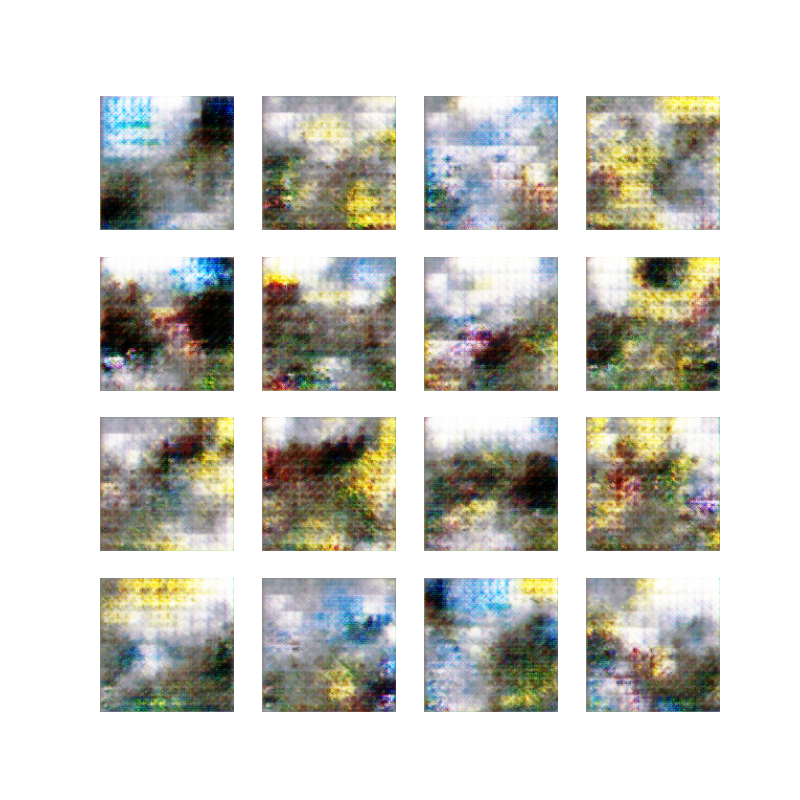
    <figcaption>cgan</figcaption>
    </figure>
    <figure style="text-align: center;">
        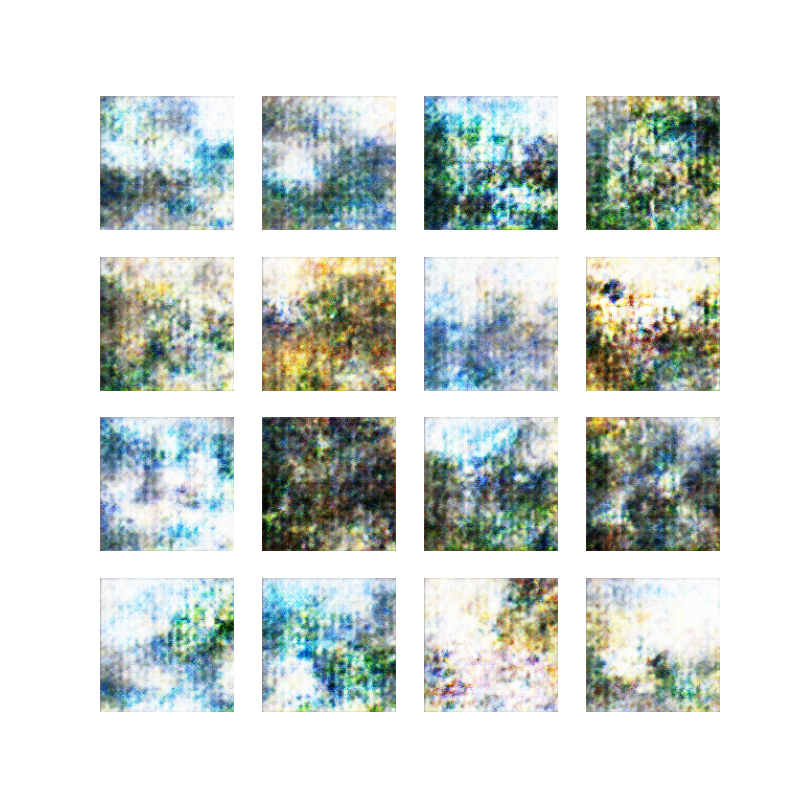
        <figcaption>dcgan</figcaption>
    </figure>

</div>

**Next, I'll compare 4 learning rates, hopefully eliminating some of them**

In [22]:
# we aldreay have the results of: run_training_for_comparison('dcgan', 0.0002, 0.5, 3, 64, 60)
run_training_for_comparison('dcgan', 0.0005, 0.5, 3, 64, 60)
run_training_for_comparison('dcgan', 0.001, 0.5, 3, 64, 60)

Training with gan=dcgan, lr=0.0005, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 16:54:51.208504
Results: 1.306783564768699 with params ('dcgan', 0.0005, 0.5, 3, 64, 60)
Finish time: 2024-10-09 17:08:41.233515

Training with gan=dcgan, lr=0.001, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 17:08:41.261876
Results: 1.0140425077572806 with params ('dcgan', 0.001, 0.5, 3, 64, 60)
Finish time: 2024-10-09 17:21:50.472008



In [23]:
run_training_for_comparison('dcgan', 0.0001, 0.5, 3, 64, 60)

Training with gan=dcgan, lr=0.0001, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 17:21:50.817681
Results: 1.1778771041489733 with params ('dcgan', 0.0001, 0.5, 3, 64, 60)
Finish time: 2024-10-09 17:34:55.712365



While 0.001 had a low FID, I can visually tell that it was learning too fast. 0.0001 seems to be the most intruiging learning rate.

<div style="float: left;">

|Learning Rate|FID|
|:--|:--|
|0.0001|1.1779|
|0.0002|0.9328|
|0.0005|1.3068|
|0.001|1.0140|
</div>

<div style="display: flex; justify-content: flex-start; align-items: flex-start; flex-wrap: wrap;">
    <figure style="text-align: center;">
        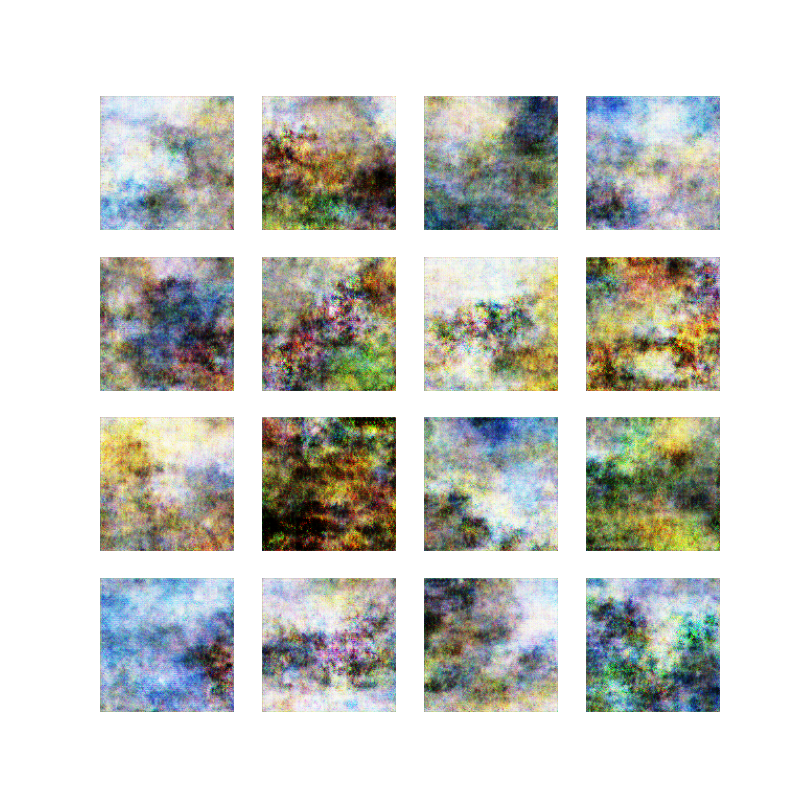
    <figcaption>0.0001</figcaption>
    </figure>
    <figure style="text-align: center;">
        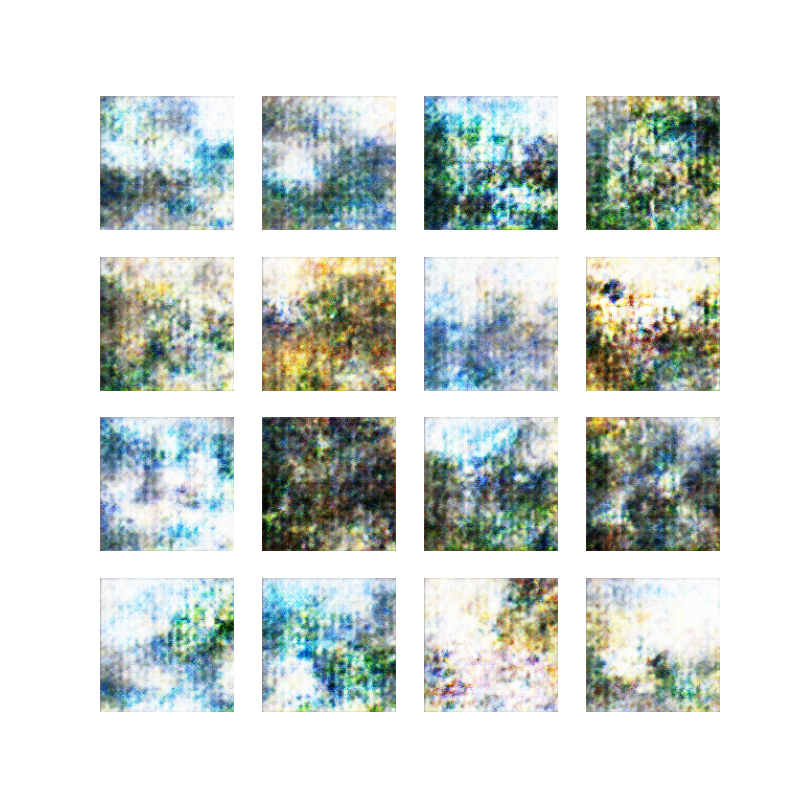
        <figcaption>0.0002</figcaption>
    </figure>
    <figure style="text-align: center;">
        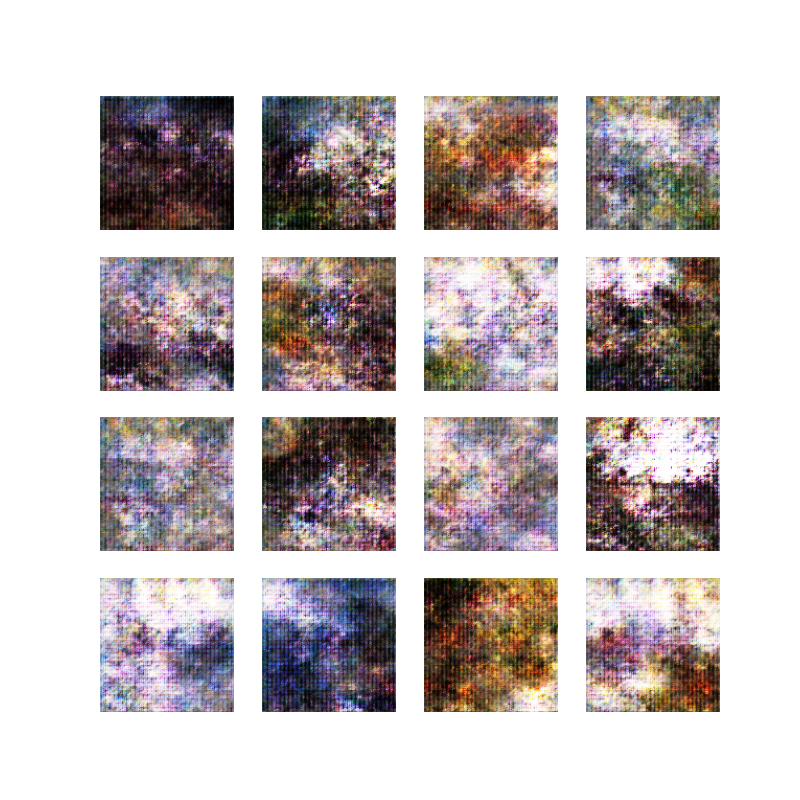
        <figcaption>0.0005</figcaption>
    </figure>
    <figure style="text-align: center;">
        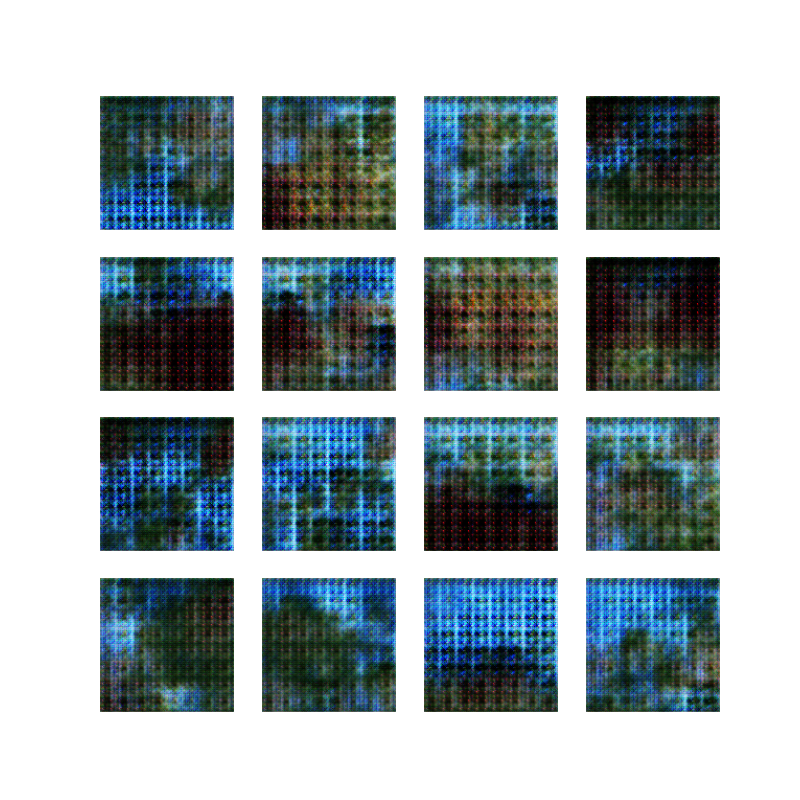
        <figcaption>0.001</figcaption>
    </figure>

</div>

**Now, I will run a smaller subset of parameter cominations at a higher epoch and compare the results.**

In [28]:
param_grid = {
    "learning_rate": [0.0001, 0.0002],
    "kernel_size": [3, 4],
    "num_filters": [64, 128]
}

param_combinations = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["kernel_size"],
    param_grid["num_filters"],
))

for learning_rate, kernel_size, num_filters in param_combinations:
    run_training_for_comparison('dcgan', learning_rate, 0.5, kernel_size, num_filters, 100)

Training with gan=dcgan, lr=0.0001, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 18:03:45.861183
Results: 1.1136594817799939 with params ('dcgan', 0.0001, 0.5, 3, 64, 100)
Finish time: 2024-10-09 18:26:24.092912

Training with gan=dcgan, lr=0.0001, beta_1=0.5, kernel_size=3, num_filters=128 @ 2024-10-09 18:26:24.094812
Results: 0.8485268270318624 with params ('dcgan', 0.0001, 0.5, 3, 128, 100)
Finish time: 2024-10-09 19:23:40.125033

Training with gan=dcgan, lr=0.0001, beta_1=0.5, kernel_size=4, num_filters=64 @ 2024-10-09 19:23:40.217664
Results: 0.7726250046126818 with params ('dcgan', 0.0001, 0.5, 4, 64, 100)
Finish time: 2024-10-09 19:47:50.368480

Training with gan=dcgan, lr=0.0001, beta_1=0.5, kernel_size=4, num_filters=128 @ 2024-10-09 19:47:50.437571
Results: 0.8977759093475186 with params ('dcgan', 0.0001, 0.5, 4, 128, 100)
Finish time: 2024-10-09 20:31:28.233038

Training with gan=dcgan, lr=0.0002, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-09 20:31:28.2358

**Below, I'll compare the best outputs from above with more epochs**

In [16]:
lr1_gen, fid_train_scores_lr1, fid_val_scores_lr1 = run_training_for_comparison('dcgan', 0.0001, 0.5, 4, 64, 200, eval_interval=20)

Training with gan=dcgan, lr=0.0001, beta_1=0.5, kernel_size=4, num_filters=64 @ 2024-10-10 22:40:12.652216
Results: 0.7474622302058325 with params ('dcgan', 0.0001, 0.5, 4, 64, 200)
Finish time: 2024-10-10 23:21:52.916251



In [17]:
lr2_gen, fid_train_scores_lr2, fid_val_scores_lr2 = run_training_for_comparison('dcgan', 0.0002, 0.5, 3, 64, 200, eval_interval=20)

Training with gan=dcgan, lr=0.0002, beta_1=0.5, kernel_size=3, num_filters=64 @ 2024-10-10 23:21:53.174462
Results: 0.9172079970393895 with params ('dcgan', 0.0002, 0.5, 3, 64, 200)
Finish time: 2024-10-10 23:52:22.831658



In [19]:
print(fid_train_scores_lr1)
print(fid_train_scores_lr2)

[5.434704244516052, 3.6133194736486054, 1.8032221804036603, 1.427400001012726, 0.891425089836644, 1.7053875620162076, 1.6994988337678556, 1.0485047931607892, 1.994189308573522, 1.3576406525341531]
[7.372124868540619, 0.9744110515183086, 0.8362638483051726, 0.7387529185915149, 0.9627128582639672, 1.2817280739175931, 0.9358182213008517, 1.7015499882423106, 1.0113447039552985, 0.8461904587908022]


# Results, Analysis, and Conclusion

Looking at the graph of epochs for each version, we can see that something around 60 epochs would like be sufficient.

Looking at the visuals, I can definitely see that the models were able to pick up on the style of Monet -- they have the character of Monets.

I think that in the future, I would try using the photos supplied and applying something like a StyleGAN to see how that looks.

Lowering beta_1 definitely seemed to make the models more stable and lowering the number of filters made the training process quicker.

The most difficult part of this project was the waiting time while models ran.

The most rewarding part was watching the image exports and seeing images come together from a model I built

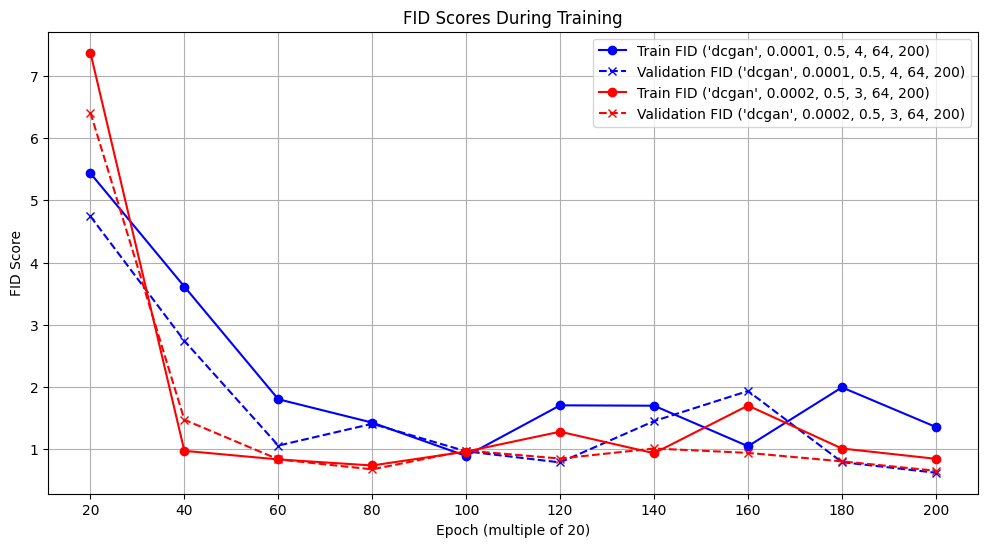

In [23]:
eval_interval = 20
eval_epochs = [i * eval_interval for i in range(1, len(fid_train_scores_lr1) + 1)]
plt.figure(figsize=(12, 6))

plt.plot(eval_epochs, fid_train_scores_lr1, label="Train FID ('dcgan', 0.0001, 0.5, 4, 64, 200)", marker="o", color="blue")
plt.plot(eval_epochs, fid_val_scores_lr1, label="Validation FID ('dcgan', 0.0001, 0.5, 4, 64, 200)", marker="x", color="blue", linestyle="--")

plt.plot(eval_epochs, fid_train_scores_lr2, label="Train FID ('dcgan', 0.0002, 0.5, 3, 64, 200)", marker="o", color="red")
plt.plot(eval_epochs, fid_val_scores_lr2, label="Validation FID ('dcgan', 0.0002, 0.5, 3, 64, 200)", marker="x", linestyle="--", color="red")

plt.xticks(eval_epochs)

plt.title("FID Scores During Training")
plt.xlabel("Epoch (multiple of 20)")
plt.ylabel("FID Score")
plt.legend()
plt.grid(True)
plt.show()

**Below, we can visually see how much better learning rate 0.0002 and kernel size 3 performs at epoch 200.**

<div style="display: flex; justify-content: flex-start; align-items: flex-start;">
    <figure style="text-align: center;">
        
    <figcaption>('dcgan', 0.0001, 0.5, 4, 64, 200)</figcaption>
    </figure>
    <figure style="text-align: center;">
        
        <figcaption>('dcgan', 0.0002, 0.5, 3, 64, 200)</figcaption>
    </figure>

</div>

In [30]:
num_images = 10
export_batch_size = 7000
for i in range(0, num_images, export_batch_size):
    noise = np.random.normal(0, 1, (export_batch_size, 128))
    imgs = lr2_gen.predict(noise)
    for j in range(export_batch_size):
        img = (imgs[j] * 255).astype(np.uint8)
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize((256, 256), Image.LANCZOS)
        img_resized.save(f'output_images/generated_img_{i + j}.png')
    tf.keras.backend.clear_session()
    gc.collect()

219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


*Below is my submission to the competition.*

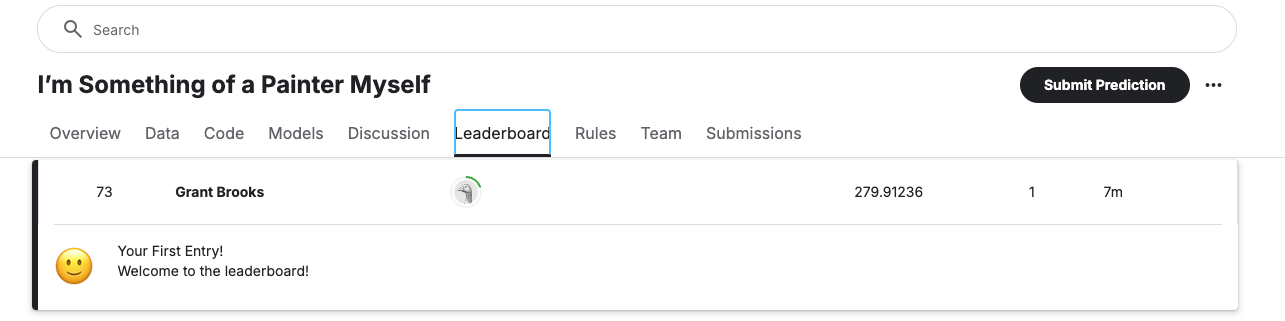